# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

In [1]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
import pandas
import geopandas
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx

import folium

In [10]:
import os, random
from shapely.geometry import Point

def load_csv_data(sep, *paths):
    """takes a bunch of paths to csv files, reads and returns them, len of return data == len(paths)
    """
    assert all([os.path.isfile(path) for path in paths]), "all entries must be valid csv files"
    return (pandas.read_csv(path, sep=sep) for path in paths)

def reverse_geocode(csv_data):
    """given a bunch of csv data containing the coordinates(lat, long) to places, do a
    reverse geocode to find their real addresses
    """
    coords = list(map(lambda x: Point(x[1].x, x[1].y), csv_data.iterrows()))
    return geopandas.tools.reverse_geocode(coords)

def reverse_geocode_multiple(*data):
    """reverse geocode multiple csv data and return them all, the len of return data == `len(data)`
    """
    return tuple(map(reverse_geocode, data))

def interactive_plot(save=False, path=None, *data):
    """Interactively plot csv data containing the coordinates of a bunch of places.
    this is done to visually explore the locations of the coordinates"""
    # merge the csv data on top of each other and reverse geocode to get the names to the places
    # the coordinates represent
    geodata = reverse_geocode(pandas.concat([*data], axis=0, ignore_index=True))
    coords = [[p.y, p.x] for p in geodata.geometry]
    map = folium.Map(location=random.choice(coords), tiles='OpenStreetMap', zoom_start=12, control_scale=True)
    # add markers for the name of each location added to map
    for i, coord in enumerate(coords):
        map.add_child(
            folium.Marker(location=coord, popup=str(geodata.address[i]),
                          icon=folium.Icon(color='green', icon='ok-sign'))
        )
        
    if save and path is not None:
        map.save(path)

    return map

#### exploring data visually to get the locations of coordinates

In [11]:
ori_file, dest_file = 'origins.csv', 'destinations.csv'
csv_data = load_csv_data(',', ori_file, dest_file)
interactive_plot(False, None, *csv_data)

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [27]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
origins, destinations = load_csv_data(',', ori_file, dest_file)
print(f'Origin Data: {len(origins)} columns\nDestination Data: {len(destinations)} columns')

Origin Data: 16 columns
Destination Data: 20 columns


**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located*. 
- Store the extent as a Shapely Polygon stored in a variable called `graph_extent`.
- Add a little bit of buffer around the extent for downloading the graph, so that you cover all routes between the points.
- See hints from this [week's hints page](https://autogis-site.readthedocs.io/en/latest/lessons/L6/exercise-6.html#hints) on how to define the extent.

In [39]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE

# join = pandas.concat([origins, destinations], axis=0, ignore_index=True)
# def polygon_from_points(points):
#    return Polygon([[p.x, p.y] for _, p in join.iterrows()])

def concat_and_reverse_geocode(*data):
    join = pandas.concat([*data], axis=0, ignore_index=True)
    return reverse_geocode(join)

all_points = concat_and_reverse_geocode(origins, destinations)

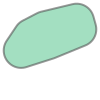

In [45]:
# get the area (buffered a little) that the coordinates cover as the graph extent 
graph_extent = all_points.unary_union.convex_hull.buffer(0.1)

graph_extent

In [46]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(graph_extent)

POLYGON ((24.590364794085968 59.22698433731699, 24.58081405981788 59.22445353467007, 24.57106019633306 59.22287757965267, 24.56119842229735 59.22227185697204, 24.551325009815415 59.222642279783074, 24.541536344608186 59.22398523196319, 24.531927985081083 59.22628760341351, 24.522593729468664 59.229526918041536, 24.513624700162314 59.23367155317616, 24.505108454159902 59.238681048272845, 24.497128128321357 59.24450649989551, 24.48976162777426 59.251091039119096, 24.48308086539243 59.258370386692526, 24.477151059771728 59.266273480542274, 24.47203009855644 59.274723169490926, 24.467767973331494 59.28363696641839, 24.464406291597147 59.29292785351351, 24.461977870590413 59.30250513175482, 24.46050641691828 59.31227530632788, 24.460006295130327 59.3221429993356, 24.46048238748981 59.3320118808914, 24.46193004631232 59.341785609505955, 24.464335139337155 59.351368772587065, 24.467674187688537 59.36066781787164, 24.47191459507992 59.36959196669673, 24.477014966023756 59.37805410019441, 24.53

In [47]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(graph_extent))

<class 'shapely.geometry.polygon.Polygon'>


- Use the polygon to fetch the drivable network data with `.graph_from_polygon()` function 
- Remember to specify correct `network_type`
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

In [48]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
graph = ox.graph_from_polygon(graph_extent, network_type='drive')

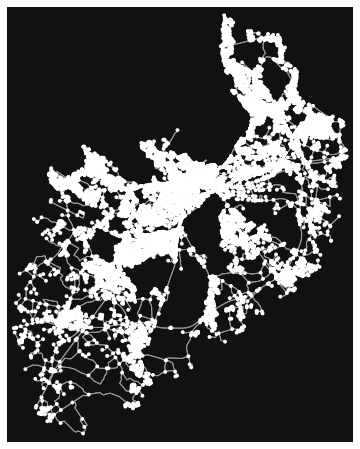

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [50]:
ox.plot_graph(graph)

In [51]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [52]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 28756 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

29354


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

In [53]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
origins_geo, destinations_geo = reverse_geocode_multiple(origins, destinations)
print(type(origins_geo), type(destinations_geo))

<class 'geopandas.geodataframe.GeoDataFrame'> <class 'geopandas.geodataframe.GeoDataFrame'>


In [57]:
def reproject_graph(graph):
    """reproject graph to metric system and return nodes and edges"""
    reproj = ox.project_graph(graph)
    return ox.graph_to_gdfs(reproj)

def change_crs(crs, *data):
    changed = (d.to_crs(crs) for d in data)
    assert all([d.crs == crs for d in changed])
    return changed

nodes, edges = reproject_graph(graph)

In [68]:
def change_crs2(crs, *data):
    return tuple(d.to_crs(crs) for d in data)

origins_geo, destinations_geo = change_crs2(nodes.crs, origins_geo, destinations_geo)

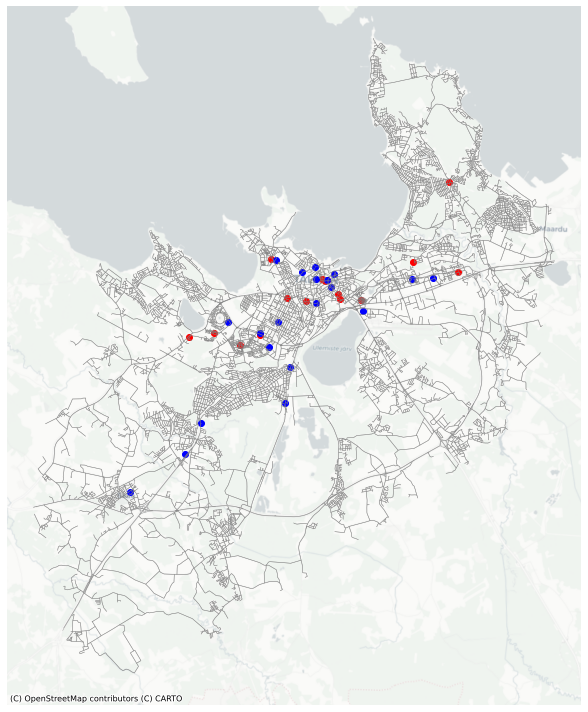

In [72]:
import contextily as ctx

def gnarly_plot(file=None):
    fig, ax = plt.subplots(figsize=(12, 10))
    edges.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.7)
    origins_geo.plot(ax=ax, color='red')
    destinations_geo.plot(ax=ax, color='blue')
    ctx.add_basemap(ax, crs=nodes.crs, source=ctx.providers.CartoDB.Positron)
    ax.axis('off')
    plt.tight_layout()
    if file is not None:
        plt.savefig(file)
    plt.show()
    
gnarly_plot('road_network_estonia_city.png')

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [81]:
def get_points_from_data(*geodata):
    """given a set of geodataframes containing geometry of shapely points
    extract the points and return them"""
    return tuple(([(point.y, point.x) for point in data['geometry']] for data in geodata))

origin_points, destination_points = get_points_from_data(origins_geo, destinations_geo)

In [82]:
graph_proj = ox.project_graph(graph)

In [98]:
def extract_nearest_node_and_id(points):
    """given a list of coordinates (lat, long), we use the nearest_node function to
    extract the node ids of the nearest nodes to each point and locate the nodes from
    the original nodes dataframe
    """
    # the fastest way to do this is using a list comprehension, followed
    # by using the zip method, but the zip is pretty nifty and involves
    # less characters so, yep let's gooo...
    x_coords, y_coords = list(zip(*points))[1], list(zip(*points))[0]
    
    # print(list(point_x), type(point_x))
    node_ids = ox.nearest_nodes(graph_proj, list(x_coords), list(y_coords))
    
    # select only those rows that nearest_nodes returns indices to.
    return nodes.loc[node_ids], node_ids

origin_nodes, origin_ids = extract_nearest_node_and_id(origin_points)
destination_nodes, destination_ids = extract_nearest_node_and_id(destination_points)

In [106]:
all_node_ids = list(set(origin_ids) | set(destination_ids))
all_nodes = nodes.loc[all_node_ids]
all_nodes.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
790046528,6.591279e+06,373195.504766,3,24.763951,59.440897,NaN,POINT (373195.505 6591278.947)
642191742,6.589297e+06,374913.617340,3,24.795379,59.423631,NaN,POINT (374913.617 6589297.416)
614466115,6.590934e+06,377734.410635,1,24.844119,59.439147,NaN,POINT (377734.411 6590934.000)
1262556101,6.587094e+06,367621.062981,4,24.668329,59.401629,NaN,POINT (367621.063 6587094.017)
6677749381,6.580699e+06,364521.509715,2,24.617817,59.343268,NaN,POINT (364521.510 6580699.408)


In [123]:
from shapely.geometry import LineString, Point

def get_shortest_route(id_pair):
    # get osmid of the data in nodes
    if len(id_pair) != 2:
        return
    return nx.shortest_path(G=graph_proj, source=id_pair[0], target=id_pair[1], weight='length')


def shortest_paths(*ids):
    """yikes"""
    return list(map(get_shortest_route, zip(*ids)))

def routes_to_gdfs(*routes):
    """convert a bunch of routes into a geodataframe with linestring geometry"""
    route_nodes = [nodes.loc[route] for route in routes]
    route_lines = [LineString(list(gdf.geometry.values)) for gdf in route_nodes]
    route_geom = geopandas.GeoDataFrame(route_lines, geometry='geometry', crs=nodes.crs, columns=['geometry'])
    route_geom['route_dist'] = route_geom.length
    route_geom['osmids'] = [str(list(gdf.index.values)) for gdf in route_nodes]
    return route_geom

routes = routes_to_gdfs(*shortest_paths(origin_ids, destination_ids))

In [ ]:
# Store the shortest path routes as LineString geometries in a GeoDataFrame called routes:


# REPLACE THE ERROR BELOW WITH YOUR OWN CODE

**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [ ]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE


In [124]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

Shortest distance: 1391 meters


In [125]:
# NON-EDITABLE TEST CELL (longest distance in the example solution is 29177 meters)
print("Longest distance:", round(routes['route_dist'].max()), "meters")

Longest distance: 25497 meters


**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

In [128]:
od_nodes = nodes.loc[all_node_ids]
od_nodes.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
790046528,6.591279e+06,373195.504766,3,24.763951,59.440897,NaN,POINT (373195.505 6591278.947)
642191742,6.589297e+06,374913.617340,3,24.795379,59.423631,NaN,POINT (374913.617 6589297.416)
614466115,6.590934e+06,377734.410635,1,24.844119,59.439147,NaN,POINT (377734.411 6590934.000)
1262556101,6.587094e+06,367621.062981,4,24.668329,59.401629,NaN,POINT (367621.063 6587094.017)
6677749381,6.580699e+06,364521.509715,2,24.617817,59.343268,NaN,POINT (364521.510 6580699.408)


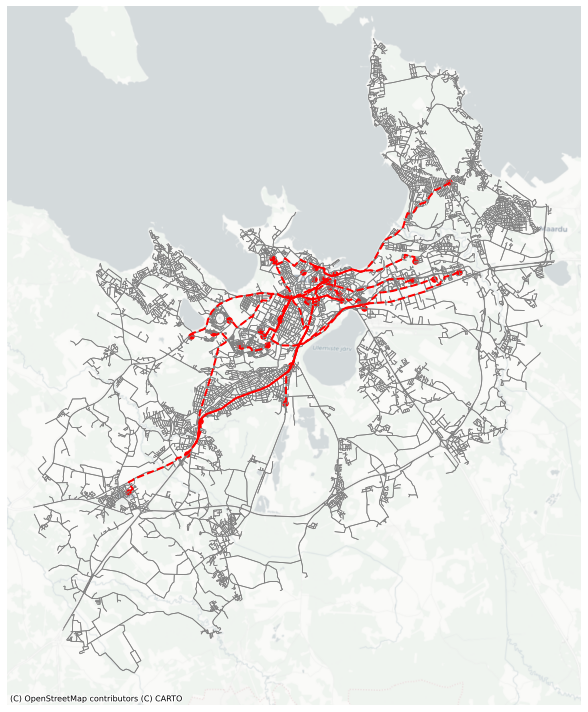

In [131]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
def another_gnarly_plot(file=None):
    fig, ax = plt.subplots(figsize=(12, 10))

    # plot edges and nodes
    edges.plot(ax=ax, linewidth=0.75, color='gray')
    # nodes.plot(ax=ax, markersize=2, color='gray')

    # add route
    routes.plot(ax=ax, color='red', linewidth=2, linestyle='--')
    
    # plot origin and destination point
    od_nodes.plot(ax=ax, markersize=30, color='red')
    
    # add basemap
    ctx.add_basemap(ax, crs=nodes.crs, source=ctx.providers.CartoDB.Positron)
    
    ax.axis('off')
    plt.tight_layout()
    if file is not None:
        plt.savefig(file)
    plt.show()

another_gnarly_plot('shortest_path_estonia_city.png')

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [132]:
total_distance = routes['route_dist'].sum()

In [133]:
# NON-EDITABLE TEST CELL (example solution: 2468 kilometers)
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


Total distance of all routes is: 145 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)